In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Python implementation of the Value Iteration algorithm

$$
p(s'\mid s, a) \doteq \Pr \{ S_t = s' \mid S_{t-1} = s, A_{t-1} = a \}, \text{for all } s',s \in \mathcal{S} \text{ and } a \in \mathcal{A(s)}  
$$

The transition function $p$ is a function that gives the probability of moving from state $s$ to state $s'$ given action $a$. It is defined as the conditional probability of the next state given the current state and action taken. The notation $\mathcal{A(s)}$ indicates that the action set may depend on the current state $s$.

### Bellman Equations

The Bellman equations express the relationship between the value of a state and the values of its successor states. They are used to derive optimal policies and value functions in Markov Decision Processes (MDPs) and reinforcement learning.

**Input:**  
$\pi$, the policy to be evaluated  
Algorithm parameter: a small threshold $\theta > 0$ determining accuracy of estimation  
Initialize $V(s)$ arbitrarily, for $s \in \mathcal{S}$, and $V(\text{terminal}) = 0$  

**Loop:**  
$\Delta \leftarrow 0$  
Loop for each $s \in \mathcal{S}$:  
&emsp;$v \leftarrow V(s)$  
&emsp;$V(s) \leftarrow \sum_a \pi(a|s) \sum_{s', r} p(s', r | s, a) [r + \gamma V(s')]$  
&emsp;$\Delta \leftarrow \max(\Delta, |v - V(s)|)$  

**until** $\Delta < \theta$

## Value Iteration {.smaller}

-   Value iteration is obtained simply by turning the Bellman optimality equation into an update rule.
-   Also note how the value iteration update is identical to the policy evaluation update except that it requires the maximum to be taken over all actions.

::: {.callout-note icon="false"}
## Value Iteration, for estimating $\pi \approx \pi_*$

**Algorithm parameter:**\
A small threshold $\theta > 0$ determining the accuracy of estimation

**Initialization:**\
Initialize $V(s)$ arbitrarily for all $s \in \mathcal{S}^+$, except that $V(\text{terminal}) = 0$

**Loop:**\
 $\Delta \leftarrow 0$\
 Loop for each $s \in \mathcal{S}$:\
  $v \leftarrow V(s)$\
  $V(s) \leftarrow \max_a \sum_{s', r} p(s', r \mid s, a) \left[ r + \gamma V(s') \right]$\
  $\Delta \leftarrow \max(\Delta, |v - V(s)|)$\
**until** $\Delta < \theta$

**Output:**\
A deterministic policy, $\pi \approx \pi_*$, such that\
 $\pi(s) = \arg\max_a \sum_{s', r} p(s', r \mid s, a) \left[ r + \gamma V(s') \right]$
:::

In [ ]:
def value_iteration(env, gamma=0.99, theta=1e-6):
    """
    Performs value iteration to compute an optimal policy.

    Args:
        env: An environment that provides:
            - env.states: a list of all states
            - env.actions(s): a list of actions available in state s
            - env.transitions(s, a): a list of (probability, next_state, reward) tuples
            - env.is_terminal(s): a function to check if a state is terminal
        gamma: Discount factor.
        theta: Small threshold for convergence.

    Returns:
        A tuple (V, pi) where:
            - V is a dict of state -> value
            - pi is a dict of state -> optimal action
    """
    V = {s: 0.0 for s in env.states}
    history = {s: [0] for s in env.states}
    for s in env.states:
        if env.is_terminal(s):
            V[s] = 0.0  # terminal states have zero value

    while True:
        delta = 0
        for s in env.states:
            if env.is_terminal(s):
                continue
            v = V[s]
            action_values = []
            for a in env.actions(s):
                q = sum(
                    prob * (reward + gamma * V[next_state])
                    for prob, next_state, reward in env.transitions(s, a)
                )
                action_values.append(q)
            V[s] = max(action_values)
            history[s].append(V[s])
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break

    # Derive the policy
    policy = {}
    for s in env.states:
        if env.is_terminal(s):
            policy[s] = None
            continue
        best_action = max(
            env.actions(s),
            key=lambda a: sum(
                prob * (reward + gamma * V[next_state])
                for prob, next_state, reward in env.transitions(s, a)
            )
        )
        policy[s] = best_action

    return V, policy, history


## 1.1 Example usage- Environment for Diabetes Care
- This environment simulates a diabetes care scenario with different states and actions.
- The states represent the health status of a patient, and the actions represent different care strategies.
- The transitions define the probabilities of moving from one state to another based on the action taken.
- The rewards are based on the health outcomes of the actions taken.

In [18]:

class DiabetesCareEnv:
    def __init__(self):
        # all possible states
        self.states = ["stable", "moderate", "critical", "dead"] 
        self._terminal_states = {"dead"}

    def is_terminal(self, s):
        return s in self._terminal_states

    def actions(self, s):
        if s == "dead":
            return []
        return ["lifestyle", "medicate", "intensive_care"]

    def transitions(self, s, a):
        """
        Returns a list of (probability, next_state, reward) tuples.
        Each action from a state leads to all possible states.
        """

        if s == "stable":
            if a == "lifestyle":
                return [
                    (0.80, "stable", 8),
                    (0.10, "moderate", 0),
                    (0.05, "critical", -10),
                    (0.05, "dead", -100),
                ]
            elif a == "medicate":
                return [
                    (0.85, "stable", 6),
                    (0.10, "moderate", -3),
                    (0.03, "critical", -10),
                    (0.02, "dead", -100),
                ]
            elif a == "intensive_care":
                return [
                    (0.90, "stable", -5),
                    (0.05, "moderate", -8),
                    (0.03, "critical", -15),
                    (0.02, "dead", -100),
                ]

        elif s == "moderate":
            if a == "lifestyle":
                return [
                    (0.50, "stable", 5),
                    (0.30, "moderate", -1),
                    (0.15, "critical", -6),
                    (0.05, "dead", -50),
                ]
            elif a == "medicate":
                return [
                    (0.60, "stable", 6),
                    (0.25, "moderate", 0),
                    (0.10, "critical", -5),
                    (0.05, "dead", -50),
                ]
            elif a == "intensive_care":
                return [
                    (0.70, "stable", 3),
                    (0.20, "moderate", -2),
                    (0.05, "critical", -10),
                    (0.05, "dead", -80),
                ]

        elif s == "critical":
            if a == "lifestyle":
                return [
                    (0.05, "stable", 2),
                    (0.10, "moderate", -3),
                    (0.50, "critical", -12),
                    (0.35, "dead", -100),
                ]
            elif a == "medicate":
                return [
                    (0.10, "stable", 3),
                    (0.30, "moderate", -2),
                    (0.50, "critical", -8),
                    (0.20, "dead", -100),
                ]
            elif a == "intensive_care":
                return [
                    (0.30, "stable", 5),
                    (0.30, "moderate", 0),
                    (0.30, "critical", -3),
                    (0.10, "dead", -90),
                ]

        elif s == "dead":
            return [(1.0, "dead", 0)]

        return []


In [20]:
env = DiabetesCareEnv()
V, policy, hist = value_iteration(env, gamma=0.95, theta=1e-4)

for state in env.states:
    print(f"State: {state:10s} | Value: {V[state]:6.2f} | Best Action: {policy[state]}")


State: stable     | Value:  22.73 | Best Action: medicate
State: moderate   | Value:  18.36 | Best Action: medicate
State: critical   | Value:   4.63 | Best Action: intensive_care
State: dead       | Value:   0.00 | Best Action: None


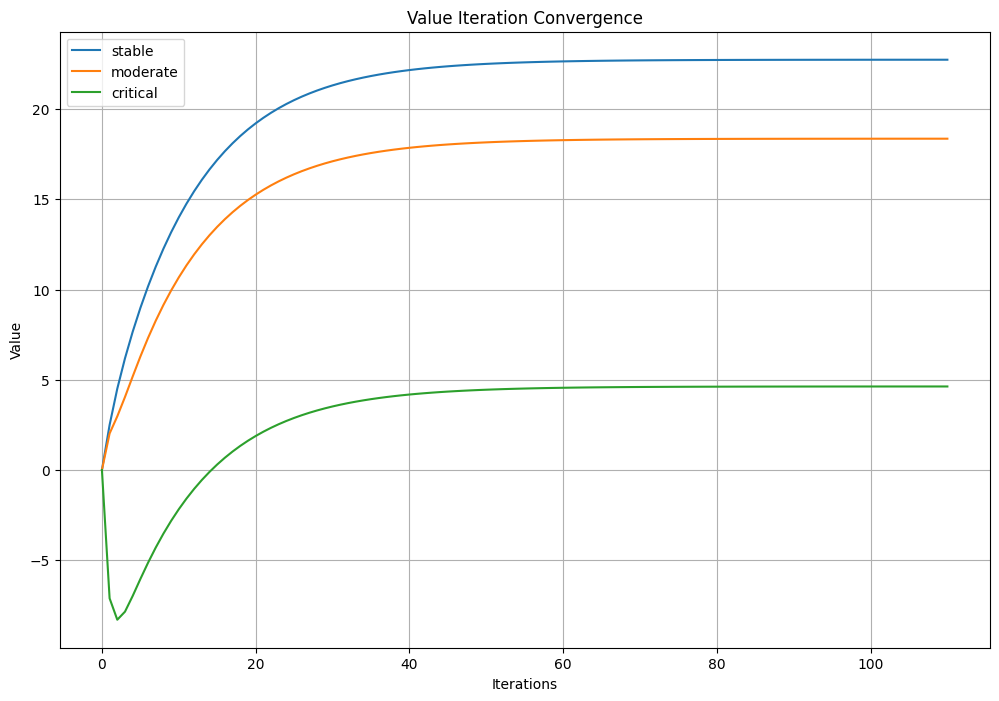

In [17]:
plt.figure(figsize=(12, 8))
for state in env.states:
    if state == "dead":
        continue
    plt.plot(hist[state], label=state)
plt.title("Value Iteration Convergence")
plt.xlabel("Iterations")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

## 1.2 Interpretation

- $\pi(s)$ = *lifestyle*: Suggests conservative management is best.
- $\pi(s)$ = *medicate*: Indicates medical intervention is effective and worth the cost.
- $\pi(s)$ = *intensive_care*: Signals high urgency; aggressive action justified.

In [33]:
interp = {
    'state': ['stable', 'moderate', 'critical', 'dead'],
    'best_action': ['lifestyle', 'medicate', 'intensive_care', "none"],
    'interpretation': [
        'Encourage self-care',
        'Best to intervene with medication',
        'Aggressive care needed to avoid death.',
        'No further action needed.'
    ]}
interp_df = pd.DataFrame(interp)
interp_df

,state,best_action,interpretation
0,stable,lifestyle,Encourage self-care
1,moderate,medicate,Best to intervene with medication
2,critical,intensive_care,Aggressive care needed to avoid death.
3,dead,none,No further action needed.


# 2. Python implementation Monte Carlo ES (Exploring Starts), for estimating $\pi \approx \pi_*$

Alternating complete steps of policy evaluation and policy improvement are performed, beginning with an arbitrary policy $\pi_0$ and ending with the optimal policy and optimal action-value function:

$$
\pi_0 \xrightarrow E q_{\pi_0} \xrightarrow I \pi_1 \xrightarrow E q_{\pi_1}\xrightarrow I \pi_2,\dots,\xrightarrow I \pi_* \xrightarrow E q_*
$$

::: {.callout-note icon="false"}
## Monte Carlo ES (Exploring Starts), for estimating $\pi \approx \pi_*$

**Initialize:**\
$\pi(s) \in \mathcal{A}(s)$ arbitrarily, for all $s \in \mathcal{S}$\
$Q(s, a) \in \mathbb{R}$ arbitrarily, for all $s \in \mathcal{S}, a \in \mathcal{A}(s)$\
$\text{Returns}(s, a) \leftarrow$ empty list, for all $s \in \mathcal{S}, a \in \mathcal{A}(s)$

**Loop forever** (for each episode):\
 Choose $S_0 \in \mathcal{S}, A_0 \in \mathcal{A}(S_0)$ randomly, such that all pairs have probability $> 0$\
 Generate an episode from $S_0, A_0$, following $\pi$:\
  $S_0, A_0, R_1, \dots, S_{T-1}, A_{T-1}, R_T$\
 $G \leftarrow 0$\
 Loop for each step of episode, $t = T-1, T-2, \dots, 0$:\
  $G \leftarrow \gamma G + R_{t+1}$\
  Unless the pair $(S_t, A_t)$ appears in\
   $S_0, A_0, S_1, A_1, \dots, S_{t-1}, A_{t-1}$:\
   Append $G$ to $\text{Returns}(S_t, A_t)$\
   $Q(S_t, A_t) \leftarrow \text{average}(\text{Returns}(S_t, A_t))$\
   $\pi(S_t) \leftarrow \arg\max_a Q(S_t, a)$
:::

In [36]:
from collections import defaultdict
import random

def monte_carlo_es(env, gamma=0.95, episodes=5000):
    Q = defaultdict(lambda: defaultdict(float)) # initializes Qs
    Q_history = defaultdict(lambda: defaultdict(list)) # initializes Q history
    Returns = defaultdict(lambda: defaultdict(list)) # initializes returns
    pi = {} 

    for s in env.non_terminal_states():
        pi[s] = random.choice(env.actions(s))

    def generate_episode(s0, a0):
        episode = []
        env.reset(s0)
        state = s0
        action = a0
        done = False

        while not done:
            next_state, reward, done = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
            action = pi[state]
        return episode

    for _ in range(episodes):
        # Exploring starts: random (state, action) pair with > 0 probability
        s0 = random.choice(env.non_terminal_states())
        a0 = random.choice(env.actions(s0))

        episode = generate_episode(s0, a0)
        G = 0
        visited = set()

        for t in reversed(range(len(episode))):
            s, a, r = episode[t] # get state, action, reward from T to 0
            G = gamma * G + r # calculate return
            if (s, a) not in visited:
                visited.add((s, a)) # store state-action pair
                Returns[s][a].append(G) # store returns
                Q[s][a] = sum(Returns[s][a]) / len(Returns[s][a]) # update Q
                Q_history[s][a].append(Q[s][a]) # store Q history
                pi[s] = max(env.actions(s), key=lambda x: Q[s][x]) # update policy

    return Q, pi, Q_history

In [ ]:
import random

class SimulatedHealthcareEnv:
    def __init__(self):
        self.states = ["stable", "moderate", "critical", "dead"]
        self._terminal_states = {"dead"}
        self.state = None

        # Hidden transition model (not visible to agent)
        self.transition_model = {
            "stable": {
                "lifestyle": [("stable", 0.80, 8), ("moderate", 0.10, -2), ("critical", 0.05, -10), ("dead", 0.05, -100)],
                "medicate": [("stable", 0.85, 6), ("moderate", 0.10, -3), ("critical", 0.03, -10), ("dead", 0.02, -100)],
                "intensive_care": [("stable", 0.90, -5), ("moderate", 0.05, -8), ("critical", 0.03, -15), ("dead", 0.02, -100)],
            },
            "moderate": {
                "lifestyle": [("stable", 0.50, 5), ("moderate", 0.30, -1), ("critical", 0.15, -6), ("dead", 0.05, -50)],
                "medicate": [("stable", 0.60, 6), ("moderate", 0.25, 0), ("critical", 0.10, -5), ("dead", 0.05, -50)],
                "intensive_care": [("stable", 0.70, 3), ("moderate", 0.20, -2), ("critical", 0.05, -10), ("dead", 0.05, -80)],
            },
            "critical": {
                "lifestyle": [("stable", 0.05, 2), ("moderate", 0.10, -3), ("critical", 0.50, -12), ("dead", 0.35, -100)],
                "medicate": [("stable", 0.10, 3), ("moderate", 0.20, -2), ("critical", 0.50, -8), ("dead", 0.20, -100)],
                "intensive_care": [("stable", 0.30, 5), ("moderate", 0.30, 0), ("critical", 0.30, -3), ("dead", 0.10, -90)],
            }
        }

    def reset(self, state=None):
        self.state = state or random.choice(self.non_terminal_states())
        return self.state

    def non_terminal_states(self):
        return [s for s in self.states if s not in self._terminal_states]

    def is_terminal(self, s):
        return s in self._terminal_states

    def actions(self, s):
        if self.is_terminal(s):
            return []
        return list(self.transition_model[s].keys())

    def step(self, action):
        transitions = self.transition_model[self.state][action] # get the transitions for the current state and action
        next_states, probs, rewards = zip(*transitions) # unpack the transitions
        idx = random.choices(range(len(probs)), weights=probs)[0] # select an index based on the probabilities
        next_state = next_states[idx] # get the next state
        reward = rewards[idx] # get the reward
        done = self.is_terminal(next_state) # check if the next state is terminal
        self.state = next_state # update the current state
        return next_state, reward, done


In [42]:
env = SimulatedHealthcareEnv()
Q, pi, q_history = monte_carlo_es(env, gamma=0.95, episodes=10000)

print("Optimal Policy Learned via Monte Carlo ES:")
for state in env.states:
    if state in pi:
        print(f"State: {state:10s} | Best Action: {pi[state]}")
    else:
        print(f"State: {state:10s} | [Terminal]")

Optimal Policy Learned via Monte Carlo ES:
State: stable     | Best Action: intensive_care
State: moderate   | Best Action: lifestyle
State: critical   | Best Action: intensive_care
State: dead       | [Terminal]


In [76]:
from collections import defaultdict
import random

def mc_control_on_policy(env, gamma=0.95, epsilon=0.1, episodes=5000):
    """
    On-policy First-Visit Monte Carlo Control for ε-soft policies.

    Returns:
        - Q: state-action value function
        - pi: policy as a probability distribution over actions
    """

    Q = defaultdict(lambda: defaultdict(float))
    Returns = defaultdict(lambda: defaultdict(list))
    pi = defaultdict(dict)  # pi[state][action] = probability

    # Initialize ε-soft policy arbitrarily
    for s in env.non_terminal_states():
        actions = env.actions(s)
        for a in actions:
            pi[s][a] = 1.0 / len(actions)

    def select_action(state):
        """Sample action from current ε-soft policy."""
        actions = list(pi[state].keys())
        probs = list(pi[state].values())
        return random.choices(actions, weights=probs)[0]

    def generate_episode():
        """Generate one episode following the current policy."""
        episode = []
        state = env.reset()
        done = False
        while not done:
            action = select_action(state)
            next_state, reward, done = env.step(action)
            episode.append((state, action, reward))
            state = next_state
        return episode

    for _ in range(episodes):
        episode = generate_episode()
        G = 0
        visited = set()

        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r
            if (s, a) not in visited:
                visited.add((s, a))
                Returns[s][a].append(G)
                Q[s][a] = sum(Returns[s][a]) / len(Returns[s][a])

                # Improve policy at state s
                actions = env.actions(s)
                best_action = max(actions, key=lambda x: Q[s][x])
                for act in actions:
                    if act == best_action:
                        pi[s][act] = 1 - epsilon + epsilon / len(actions)
                    else:
                        pi[s][act] = epsilon / len(actions)

    return Q, pi

env = SimulatedHealthcareEnv()
Q, pi = mc_control_on_policy(env, gamma=0.95, epsilon=0.1, episodes=10000)

print("Learned ε-soft Policy:")
for state in env.non_terminal_states():
    print(f"State: {state}")
    for action in pi[state]:
        print(f"  Action: {action:15s} | Prob: {pi[state][action]:.2f}")



Learned ε-soft Policy:
State: stable
  Action: lifestyle       | Prob: 0.03
  Action: medicate        | Prob: 0.93
  Action: intensive_care  | Prob: 0.03
State: moderate
  Action: lifestyle       | Prob: 0.03
  Action: medicate        | Prob: 0.03
  Action: intensive_care  | Prob: 0.93
State: critical
  Action: lifestyle       | Prob: 0.03
  Action: medicate        | Prob: 0.03
  Action: intensive_care  | Prob: 0.93


# 3. Python implementation of SARSA algorithm

# 4. Python implementation of Q-learning algorithm